1. setup pipeline
2. FIRST USECASE: login via spotify, enter a playlist, it plays the (15sec) popular moments as a medley
    * deploy via streamlit and github
    * everything gets downloaded for 2nd UC
    * store in AWS DB
3. apply ML
4. SECOND USECASE: predict popular moments

## TODO
* yt search takes only the first search result
* search for 'pass' and do something about it
* pandadise: proxy file
* check device_id regularly in mg
* make popup optional in mg
* what do to with yt's weird last chapter values
* match beats via spotify and choose the play order
* make asynchronous (Handler instantiation (selenium), create medley, ..)
* let users login on their own spotify
* ProxyServer: maintain a list of burned/banned proxies
* refresh spotify token for playback sdk

### Open questions
* youtube advertisment?
* what and how ML

## Streamlit

* to show test.html needs:
```python -m http.server``` from anaconda prompt in final folder
opens http://127.0.0.1:8000/test.html#


* to show streamlit
```streamlit run streamlit.py``` from anaconda prompt at streamlit.py location
opens http://localhost:8501

In [69]:
from src.utils import install_pip_pkg
install_pip_pkg({'streamlit'})

In [133]:
streamlit_requirements = '\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None))
with open('requirements.txt', 'w') as f:
    f.write(streamlit_requirements)
    
print(streamlit_requirements)

requests==2.27.1
json==2.0.9
selenium.webdriver==4.3.0
pandas==1.4.2


In [134]:

        # TODO needs access token
        html_string = '''
             <script language="javascript">
             window.onSpotifyWebPlaybackSDKReady = () => {
               const token = sp_access_token; 
               const player = new Spotify.Player({
                 name: 'Web Playback SDK Quick Start Player',
                 getOAuthToken: cb => { cb(token); }
               });
             }
             </script>
        '''
 
        # old example
        '''
        <h1>HTML string in RED</h1>

        <script language="javascript">
          document.querySelector("h1").style.color = "red";
          console.log("Streamlit runs JavaScript");
          alert("Streamlit runs JavaScript");
        </script>
        '''
  # following https://developer.spotify.com/documentation/embeds/guides/using-the-iframe-api/
    html_string = '''
        <div id="embed-iframe"></div>
        <script src="https://open.spotify.com/embed-podcast/iframe-api/v1" async>
        </script>
        <script type="text/javascript"> 
        window.onSpotifyIframeApiReady = (IFrameAPI) => {
          let element = document.getElementById('embed-iframe');
          let options = {
              width: '60%',
              height: '200',
              uri: 'spotify:episode:7makk4oTQel546B0PZlDM5'
            };
          let callback = (EmbedController) => {};
          IFrameAPI.createController(element, options, callback);
        };
        </script>

        '''

    
    #playlist_uri = sp_pl_id[sp_pl_selected]
        #uri_link = 'https://open.spotify.com/embed/playlist/' + playlist_uri
        #components.iframe(uri_link, height=300)

# Spotify Search

unlimited with timeouts that should be handled by backoff strategy


In [3]:
# import libraries
import os 
from src.SpotifyHandler import SpotifyHandler
from src.AsyncHandler import AsyncHandler

sp_handler = SpotifyHandler(AsyncHandler(), os.path.join(os.getcwd(), '.env_spotify'))

In [4]:
kwargs = {'q' : 'top 80s', 'limit' : 10, 'type' : 'playlist'}
res = sp_handler.retrieve('search', **kwargs)

In [5]:
pl_id = []
pl_name = []
pl_image_url = []
pl_track_total = []
for pl_number in range(kwargs['limit']):
    pl_id.append(res['playlists']['items'][pl_number]['id'])
    pl_name.append(res['playlists']['items'][pl_number]['name'])
    pl_track_total.append(res['playlists']['items'][pl_number]['tracks']['total'])
    pl_image_url.append(res['playlists']['items'][pl_number]['images'][-1]['url'])

pl_id, pl_name, pl_image_url, pl_track_total

(['7LOFIDkd8Wk676m7QNIW11',
  '37i9dQZF1DXbdTzLVot2nl',
  '5vtOJ6CiRwN6B7bcLhm84R',
  '37i9dQZF1DXb57FjYWz00c',
  '6b2FpCLYbK0E0fEG7y40Ek',
  '0dCnhQXoegzbusbGErPxGF',
  '3ar1dn1yCgNu9La4qs2VEy',
  '1UzCoYV8xkoNLZY50RTdNq',
  '4adb84lXzTD6zvXDSMw8lS',
  '15NS7MuknheNMNvtzfH59R'],
 ['Top 80s Pop Español México - Antro Party Musica para Boda - Top 20 Fiesta',
  'Good Feeling 80s',
  'Top 100 80s Songs',
  '80s Hits',
  'Top 80´s Rock',
  '80s Top 40 Hits',
  'Top 80s Songs From Movies',
  '80s 90s Classics',
  '80s Chart Hits',
  "TOP 80'S POP & NEWWAVE (HITS ONLY)"],
 ['https://mosaic.scdn.co/60/ab67616d0000b27320e3b8f2b044117fe02790e1ab67616d0000b2734feb16c50d6ddd756222a8b6ab67616d0000b27356233c81a88e0bfc8fc3c094ab67616d0000b273bbcfa686475d805a191d1d43',
  'https://i.scdn.co/image/ab67706f00000003175531e991b24402d13ab191',
  'https://mosaic.scdn.co/60/ab67616d0000b2731336b31b6a1799f0de5807acab67616d0000b2734121faee8df82c526cbab2beab67616d0000b2739977eb01e4e40c8357435ef9ab67616d0000b273

In [6]:
res = sp_handler.retrieve('playlist', res['playlists']['items'][0]['id'])


In [7]:
track_id = []
track_name = []
track_popularity = []
track_artist = []
for track_number in range(kwargs['limit']):
    track_id.append(res['tracks']['items'][track_number]['track']['id'])
    track_name.append(res['tracks']['items'][track_number]['track']['name'])
    track_popularity.append(res['tracks']['items'][track_number]['track']['popularity'])

    artist_len = len(res['tracks']['items'][track_number]['track']['artists'])
    artists = []
    for artist_number in range(artist_len):
        artists.append(res['tracks']['items'][track_number]['track']['artists'][artist_number]['name'])
    track_artist.append(', '.join(artists))
# possibly track->album->{id (to get genre), name, release_date, images}
        

In [8]:
track_id, track_name, track_artist, track_popularity

(['1uKjQoh8JZj9ryuYRhpd7E',
  '05PIJWWaYGCF4cMk5sHQPR',
  '6MBQGvGsDRq0QXRv7p8kha',
  '4N8CvIZVlCndbGxbp8J7nw',
  '07qUzGpXiq4NkOoMKnbeMY',
  '2Luer8kLzFkQcjw8CU8x35',
  '6Qv8CGPZRRwQs3pLw8EYxh',
  '2Bbvlv1uslztpJbGgEsckH',
  '0lz6aru2wknAhMIsvKUN3g',
  '5JiRlyOGE2EYvzLyex6pdK'],
 ['Ahora Te Puedes Marchar',
  'La Chica De Humo - En Vivo Desde Auditorio Nacional, México/ 2007',
  'Con Todos Menos Conmigo',
  'Bazar',
  'El Rey Azul - En Vivo Los Estudios Churubusco México DF/2011',
  'Cuando Calienta El Sol',
  'Tu Y Yo Somos Uno Mismo',
  'El Noa Noa',
  'No Controles',
  'Autos, Moda Y Rock N Roll'],
 ['Luis Miguel',
  'Emmanuel',
  'Timbiriche',
  'Flans',
  'Emmanuel',
  'Luis Miguel',
  'Timbiriche',
  'Juan Gabriel',
  'Flans',
  'Fandango'],
 [77, 53, 0, 48, 0, 58, 0, 50, 0, 49])

In [9]:
res['tracks']['items'][0]

{'added_at': '2018-08-28T16:10:38Z',
 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/21rayvpsqxrj7polfdiq23swy'},
  'href': 'https://api.spotify.com/v1/users/21rayvpsqxrj7polfdiq23swy',
  'id': '21rayvpsqxrj7polfdiq23swy',
  'type': 'user',
  'uri': 'spotify:user:21rayvpsqxrj7polfdiq23swy'},
 'is_local': False,
 'primary_color': None,
 'track': {'album': {'album_type': 'album',
   'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2nszmSgqreHSdJA3zWPyrW'},
     'href': 'https://api.spotify.com/v1/artists/2nszmSgqreHSdJA3zWPyrW',
     'id': '2nszmSgqreHSdJA3zWPyrW',
     'name': 'Luis Miguel',
     'type': 'artist',
     'uri': 'spotify:artist:2nszmSgqreHSdJA3zWPyrW'}],
   'available_markets': ['AD',
    'AE',
    'AG',
    'AL',
    'AM',
    'AO',
    'AR',
    'AT',
    'AU',
    'AZ',
    'BA',
    'BB',
    'BD',
    'BE',
    'BF',
    'BG',
    'BH',
    'BI',
    'BJ',
    'BN',
    'BO',
    'BR',
    'BS',
    'BW',
    'BY',
 

# Spotify AudioFeatures

In [11]:
track_afeat = sp_handler.retrieve('audio_features', track_id[0])
track_aanal = sp_handler.retrieve('audio_analysis', track_id[0])        

In [12]:
track_afeat

[{'danceability': 0.78,
  'energy': 0.877,
  'key': 6,
  'loudness': -3.683,
  'mode': 0,
  'speechiness': 0.0427,
  'acousticness': 0.148,
  'instrumentalness': 2.36e-06,
  'liveness': 0.0627,
  'valence': 0.909,
  'tempo': 133.263,
  'type': 'audio_features',
  'id': '1uKjQoh8JZj9ryuYRhpd7E',
  'uri': 'spotify:track:1uKjQoh8JZj9ryuYRhpd7E',
  'track_href': 'https://api.spotify.com/v1/tracks/1uKjQoh8JZj9ryuYRhpd7E',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1uKjQoh8JZj9ryuYRhpd7E',
  'duration_ms': 191973,
  'time_signature': 4}]

In [13]:
track_aanal.keys()

dict_keys(['meta', 'track', 'bars', 'beats', 'sections', 'segments', 'tatums'])

In [20]:
track_aanal['segments']

[{'start': 0.0,
  'duration': 1.03596,
  'confidence': 0.0,
  'loudness_start': -60.0,
  'loudness_max_time': 0.0,
  'loudness_max': -60.0,
  'loudness_end': 0.0,
  'pitches': [0.434,
   0.478,
   0.456,
   0.526,
   0.445,
   0.458,
   0.482,
   0.563,
   0.668,
   0.843,
   0.981,
   1.0],
  'timbre': [0.0,
   171.13,
   9.469,
   -28.48,
   57.491,
   -50.067,
   14.833,
   5.359,
   -27.228,
   0.973,
   -10.64,
   -7.228]},
 {'start': 1.03596,
  'duration': 0.43832,
  'confidence': 1.0,
  'loudness_start': -60.0,
  'loudness_max_time': 0.02234,
  'loudness_max': -10.305,
  'loudness_end': 0.0,
  'pitches': [0.799,
   0.711,
   1.0,
   0.716,
   0.625,
   0.703,
   0.518,
   0.384,
   0.426,
   0.67,
   0.629,
   0.927],
  'timbre': [30.341,
   41.103,
   -179.211,
   195.055,
   -19.01,
   88.853,
   -21.598,
   59.847,
   5.57,
   57.266,
   65.16,
   -13.542]},
 {'start': 1.47429,
  'duration': 0.45878,
  'confidence': 1.0,
  'loudness_start': -54.966,
  'loudness_max_time': 0.0

# YouTube Search

unlimited thanks to 124 API keys powering the lemnos API

lemnos API: https://yt.lemnoslife.com/
possible search parameters: https://developers.google.com/youtube/v3/docs/search/list
possible video genres: https://developers.google.com/youtube/v3/docs/videoCategories

In [40]:
import requests
import json

query = track_name.replace(' ', '+')

# order = {date, rating, relevance, title, videoCount, viewCount) see above link
lemnos_yt_url = f'https://yt.lemnoslife.com/search?part=id,snippet&q={query}&type=video&order=viewCount'

response = requests.get(lemnos_yt_url)
if response.status_code != 200:
    raise Exception(f'Returned code {response.status_code} for url = {lemnos_yt_url}')
    
yt_search = response.json()


In [50]:
video_number = 0
vid_id = yt_search['items'][video_number]['id']['videoId']
vid_name = yt_search['items'][video_number]['snippet']['title']

In [51]:
vid_id, vid_name

('r3Pr1_v7hsw',
 'Foreigner - I Want To Know What Love Is (Official Music Video)')

# Proxies

possibility for getting blocked; needs IP spoofing

rapidAPI proxy https://rapidapi.com/yuananf/api/proxy12/

import datetime

x = datetime.datetime.now()
print(x)20 requests per day

In [33]:
import asyncio

from src.utils import install_pip_pkg
install_pip_pkg({'proxybroker'})

from proxybroker import Broker

def get_random_proxy():
    """
    Get random proxy from PROXY_FILE
    """
    lines = open(PROXY_FILE).read().splitlines()
    rproxy = random.choice(lines)
    PROXY =  rproxy


async def save(proxies, filename):
    """
    Save proxies to a file.
    """
    with open(filename, 'w') as file:
        while True:
            proxy = await proxies.get()
            if proxy is None:
                break
            # Check accurately if the proxy is working.
            print(proxy.__dict__)
            if proxy.is_working:
                protocol = 'https'
                line = '{protocol}://{proxy.host}:{proxy.port}\n'
                file.write(line)

PROXY_FILE = 'proxy_list.txt'
proxies = asyncio.Queue()
broker = Broker(proxies)
print('test2')
tasks = asyncio.gather(broker.find(types=['HTTPS'], limit=5),
                       save(proxies, filename= PROXY_FILE))
print('test1')
loop = asyncio.get_event_loop()
print('test')
loop.run_until_complete(tasks)

test2
test1
test


RuntimeError: This event loop is already running

C:\Users\circl\anaconda3\lib\site-packages\charset_normalizer\api.py:105: UserWarning: Trying to detect encoding from a tiny portion of (14) byte(s).
  warn('Trying to detect encoding from a tiny portion of ({}) byte(s).'.format(length))


{'host': '54.38.146.209', 'port': 8000, 'expected_types': {'CONNECT:25', 'HTTP', 'CONNECT:80', 'HTTPS'}, '_timeout': 8, '_ssl_context': <ssl.SSLContext object at 0x00000255886AD940>, '_types': {'HTTPS': None}, '_is_working': True, 'stat': {'requests': 2, 'errors': Counter()}, '_ngtr': None, '_geo': GeoData(code='FR', name='France', region_code='Unknown', region_name='Unknown', city_name='Unknown'), '_log': [('INFO', 'Selected judge: <Judge [HTTPS] www.proxy-listen.de>', 0), ('HTTPS', 'Initial connection', 0), ('HTTPS', 'Connection: success', 0.060178279876708984), ('HTTPS', "Request: b'CONNECT www.proxy-listen.de:443 HTTP/1.1\\r\\nHost:...", 0), ('HTTPS', "Received: 74 bytes: b'HTTP/1.1 200'", 0.05019426345825195), ('HTTPS', 'SSL: Initial connection', 0), ('HTTPS', 'SSL: Connection: success', 0.06000709533691406), ('HTTPS', "Request: b'GET /azenv.php HTTP/1.1\\r\\nUser-Agent: PxBroker/0...", 0), ('HTTPS', "Received: 988 bytes: b'HTTP/1.1 200'", 0.2598083019256592), ('HTTPS', 'Get: succ

### useless rapidAPI

In [27]:
# IP spoofing
import requests, json
from src.utils import ConfigHandler
from datetime import datetime

proxy_dict = {
    'ephemeral_proxy' : {
        'check_url' : "https://ephemeral-proxies.p.rapidapi.com/v1/service_status",
        'get_url' : "https://ephemeral-proxies.p.rapidapi.com/v1/proxy",
        'interval' : 'month',
        'interval_strftime_code' : '%b',
        'X-RapidAPI-Host' : 'ephemeral-proxies.p.rapidapi.com',
        'request_limit' : 100,
        'availability_in_sec' : 1800
    }
}
        
provider = 'ephemeral_proxy'
        
interval = datetime.now().strftime(proxy_dict[provider]['interval_strftime_code'])
ch = ConfigHandler('proxy_request_limit.config')
headers = {
    "X-RapidAPI-Key": "your-api-key",
    "X-RapidAPI-Host": proxy_dict[provider]['X-RapidAPI-Host']
}

proxy_count = None
response = None

with ch.alter(provider) as ach:
    if ach[f"last_{proxy_dict[provider]['interval']}"] != interval:
        ach[f"last_{proxy_dict[provider]['interval']}"] = interval
        proxy_count = 0
        ach['count'] = str(proxy_count)
        proxy_limit = proxy_dict[provider]['request_limit']
        ach['limit'] = str(proxy_limit)       
        
    else:
        proxy_count = ach.getint('count') 
        proxy_limit = ach.getint('limit')
        
    headers['X-RapidAPI-Key'] = ach['key'] 
    response = requests.request("GET", proxy_dict[provider]['get_url'], headers=headers)
    ach['count'] = str(proxy_count + 1)
    
response_json = json.loads(response.text)


In [38]:
from pandas import read_csv as pd_read_csv
from pandas import json_normalize as pd_json_normalize
from pandas import concat as pd_concat
from pandas import DataFrame as pd_DataFrame
import os 

path = 'proxies'
df_proxy = None

if os.path.isfile(path):
    df_proxy = pd_read_csv(path)
    df_proxy.drop(columns=df_proxy.columns[0], inplace=True)
else:
    df_proxy = pd_DataFrame()
    
df_proxy = pd_concat([df_proxy, pd_json_normalize(response_json)], axis=0)
df_proxy = df_proxy[df_proxy['proxy.id'].duplicated(keep='last')]
df_proxy.to_csv('proxies')

In [3]:
from pandas import read_csv as pd_read_csv
df_proxy = pd_read_csv('proxies')

In [4]:
df_proxy

,Unnamed: 0,success,proxy.id,proxy.host,proxy.port,proxy.expires_at,proxy.whitelisted_ips,proxy.visibility.ip,proxy.visibility.country,proxy.visibility.country_iso,...,proxy.visibility.latitude,proxy.visibility.longitude,proxy.visibility.timezone,proxy.visibility.asn,proxy.visibility.asn_org,proxy.features.static,proxy.features.supported_protocols.socks4,proxy.features.supported_protocols.socks5,proxy.features.supported_protocols.http,proxy.features.supported_protocols.https
0,0,True,7d0d1dc64496bbdda5cbbee77addecca,lc13e.ep-proxy.net,33599,2022-07-25T11:31:21.000Z,['95.91.245.225'],185.61.217.223,Russia,RU,...,55.7386,37.6068,Europe/Moscow,AS9009,M247 Ltd,True,False,False,True,True


In [5]:
port = int(df_proxy['proxy.port'][0])
ip = df_proxy['proxy.visibility.ip'][0]
host = df_proxy['proxy.host'][0]
ip

'185.61.217.223'

# Proxy to Selenium

In [78]:
!pip install fake_useragent

  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=d1ba7f32d55363ee469f4f96039b94f4271fdf4c1ed4d6826fd7b2f8038b0b3e
  Stored in directory: c:\users\circl\appdata\local\pip\cache\wheels\a0\b8\b7\8c942b2c5be5158b874a88195116b05ad124bac795f6665e65
Successfully built fake-useragent


Das System kann den angegebenen Pfad nicht finden.


In [124]:
from selenium import webdriver 
import pandas as pd 
from selenium.webdriver.common.by import By 
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.firefox.service import Service
import os

driver_path = r'geckodriver\geckodriver.exe'
driver_path = os.path.join(os.getcwd(), driver_path)

options = Options()
#options.headless = True

In [15]:

#PROXY = "<HOST:PORT>"
#webdriver.DesiredCapabilities.FIREFOX['proxy'] = {
#    "httpProxy": PROXY,
#    "ftpProxy": PROXY,
#    "sslProxy": PROXY,
#    "proxyType": "MANUAL",
#}          
#     "noProxy":None,
#    "class":"org.openqa.selenium.Proxy",
#    "autodetect":False

# you have to use remote, otherwise you'll have to code it yourself in python to 
#driver = webdriver.Remote("http://localhost:4444/wd/hub", webdriver.DesiredCapabilities.FIREFOX)

# OR

#with webdriver.Firefox() as driver:
#    driver.get("https://selenium.dev")


from selenium.webdriver.firefox.options import Options    

ip = '198.59.191.234'
port = 8080
options = Options()
options.set_preference("network.proxy.type", 1)
options.set_preference("network.proxy.http", ip)    
options.set_preference("network.proxy.http_port", port)
options.set_preference("network.proxy.ssl", ip)    
options.set_preference("network.proxy.ssl_port", port)

from fake_useragent import UserAgent
ua = UserAgent()
userAgent = ua.random
options.add_argument(f'user-agent={userAgent}')  
#options.set_preference("general.useragent.override","whater_useragent")
'''
options.set_preference('network.proxy.type', 1)
options.set_preference('network.proxy.socks', ip)
options.set_preference('network.proxy.socks_port', port)
options.set_preference('network.proxy.socks_remote_dns', False)


# OTHER TEST

from selenium import webdriver 
#from selenium.webdriver.support.ui import WebDriverWait 
#from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.firefox.service import Service
import os


driver_path = r'geckodriver\geckodriver.exe'
driver_path = os.path.join(os.getcwd(), driver_path)
        
PROXY = f'{ip}:{port}'# "<HOST:PORT>"
webdriver.DesiredCapabilities.FIREFOX['proxy'] = {
"httpProxy": PROXY,
"proxyType": "MANUAL",

}

with webdriver.Firefox(service = Service(driver_path)) as driver:
    driver.get('https://whatismyipaddress.com/')
    
'''
print()

"\noptions.set_preference('network.proxy.type', 1)\noptions.set_preference('network.proxy.socks', ip)\noptions.set_preference('network.proxy.socks_port', port)\noptions.set_preference('network.proxy.socks_remote_dns', False)\n"

# Selenium to Youtube mostReplayed

In [4]:
from src.utils import install_pip_pkg
install_pip_pkg({'selenium'})

In [31]:
del yt_handler

In [36]:
from src.YoutubeHandler import YoutubeHandler
yt_handler = YoutubeHandler()
yt_handler.init_virt_browser(options = options, wait_in_sec = 70)
#yt_handler.get('https://www.myip.com/')

### Selenium Example

In [2]:
from src.YoutubeHandler import YoutubeHandler
yt_handler = YoutubeHandler()
yt_handler.init_virt_browser()
driver, browser = yt_handler.get_browsers()

In [3]:
video_path = f'https://www.youtube.com/watch?v=I-i4fat9_fQ'#{vid_id}'
driver.get(video_path)


In [5]:
# if video has chapters the heatmap is divided
# "ytp-heat-map-container"  -> many 'ytp-heat-map-chapter' -> in each one '.ytp-heat-map-path'
from selenium.webdriver.common.by import By 
from selenium.webdriver.support import expected_conditions as EC
heatmaps = browser.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, '.ytp-heat-map-path')))
result_len = len(heatmaps)
if result_len > 1:
    chapter_times = browser.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, '.ytp-heat-map-chapter')))
    chapter_times = [time.get_attribute('style') for time in chapter_times]
else:
    chapter_times = [0, duration]
heatmaps = [d.get_attribute('d') for d in heatmaps]

chapter_times, heatmaps

(['width: 19px; left: 0px;',
  'width: 199px; left: 21px;',
  'width: 82px; left: 222px;',
  'width: 27px; left: 306px;',
  'width: 207px; left: 335px;',
  'width: 257px; left: 544px;',
  'width: 26px; left: 803px;'],
 ['M 0.0,100.0 C 33.3,91.7 66.7,60.5 166.7,58.5 C 266.7,56.5 366.7,93.4 500.0,90.0 C 633.3,86.6 733.3,51.0 833.3,41.3 C 933.3,31.5 966.7,29.5 1000.0,41.3 C 1033.3,53.0 1000.0,88.3 1000.0,100.0',
  'M 0.0,100.0 C 0.0,88.3 -4.0,53.0 0.0,41.3 C 4.0,29.5 8.0,35.1 20.0,41.3 C 32.0,47.5 44.0,62.7 60.0,72.4 C 76.0,82.2 84.0,87.0 100.0,90.0 C 116.0,93.0 124.0,87.6 140.0,87.5 C 156.0,87.4 164.0,88.9 180.0,89.4 C 196.0,89.9 204.0,96.5 220.0,90.0 C 236.0,83.5 244.0,57.1 260.0,57.1 C 276.0,57.1 284.0,83.4 300.0,90.0 C 316.0,96.6 324.0,90.0 340.0,90.0 C 356.0,90.0 364.0,90.0 380.0,90.0 C 396.0,90.0 404.0,90.0 420.0,90.0 C 436.0,90.0 444.0,96.3 460.0,90.0 C 476.0,83.7 484.0,60.2 500.0,58.6 C 516.0,57.0 524.0,75.8 540.0,82.1 C 556.0,88.3 564.0,88.5 580.0,90.0 C 596.0,91.5 604.0,89.4 620

In [116]:
from re import findall as re_findall
from re import match as re_match

def extract_moment(chapter_times, heatmaps, total_duration):

    graph = {'x': [], 'y': []}
    for i, time in enumerate(chapter_times):
        # do not represent actual ms times but px factors inside of youtube's progress bar
        duration_factor, offset_factor = re_match('width: (\d+)px; left: (\d+)px;', time).group(1, 2)  
                
        # regex for x,y pairs; first pair is always 0.0,100.0 
        # the last pair is something weird; seems out of bounds
        coords = re_findall('\s([\d.]+,[\d.]+)\s', heatmaps[i])[1:]
        
        # split into x and y list
        coords = list(zip(*[coord.split(',') for coord in coords]))
        
        #print(duration_factor, offset_factor,coords[0][2], coords[0][-2])
        tmp = [(float(i) * float(duration_factor) / 1000.0) + float(offset_factor) for i in coords[0]]
        graph['x'].extend(tmp)
        graph['y'].extend([100.0 - float(i) for i in coords[1]])
    
    assert graph['x'][-1] == max(graph['x'])
    graph['x'] = [i * total_duration / graph['x'][-1] for i in graph['x']]
    return graph 

total_duration_in_ms = 192 * 1000
graph = extract_moment(chapter_times, heatmaps, total_duration_in_ms)
graph

{'x': [145.43894711186934,
  728.0682427492077,
  1164.8218376797463,
  2183.767974652693,
  2765.960516695101,
  3639.4677065561773,
  4076.2213014867166,
  4367.535949305386,
  4512.974896417255,
  4991.469656349012,
  4991.469656349012,
  5176.154033633925,
  5914.89154277358,
  6468.94467462832,
  7761.735315622716,
  8500.472824762366,
  9608.57908847185,
  10347.316597611503,
  11455.422861320983,
  12194.160370460637,
  13302.266634170119,
  14041.004143309772,
  15149.110407019252,
  15887.847916158908,
  16995.95417986839,
  17734.691689008043,
  18842.797952717523,
  19581.535461857176,
  20689.641725566653,
  21428.37923470631,
  22536.485498415794,
  23275.223007555447,
  24383.329271264927,
  25122.066780404584,
  26230.17304411406,
  26968.91055325371,
  28077.016816963194,
  28815.754326102848,
  29923.86058981233,
  30662.598098951985,
  31770.704362661465,
  32509.44187180112,
  33617.5481355106,
  34356.285644650256,
  35464.391908359736,
  36203.12941749939,
  37311.

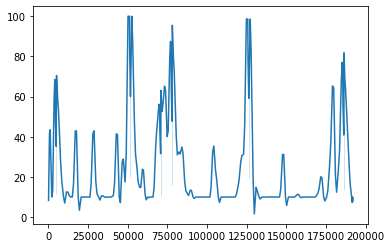

In [117]:
import seaborn as sns
g = sns.lineplot(x=graph['x'], y=graph['y'])

In [164]:
def sliding_window(graph, window_size_in_ms):
    offset = None
    return offset

import pandas as pd
df_graph = pd.DataFrame(data = graph)
df_graph.rename(columns = {'x': 'time', 'y': 'popularity'}, inplace=True)

df_graph['time_shift'] = df_graph[['time']].diff().set_index(df_graph.index - 1)
df_graph.fillna(0, inplace=True)
df_graph['scaled_popularity'] = df_graph['time_shift'] * df_graph['popularity']
df_graph.loc[14:120, 'scaled_popularity'].cumsum()

window_size_in_sec = 15
window_dt = pd.offsets.Second(window_size_in_sec)

<AxesSubplot:>

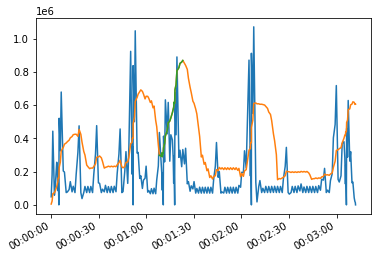

In [176]:
df_windowed_popularity = (
                df_graph 
                    .set_index(pd.to_datetime(df_graph['time'].array, unit='ms'))['scaled_popularity']
                    .rolling(window=f'{window_size_in_sec}s')
                    .sum()
                     )
                    
snippet_end = df_windowed_popularity.idxmax()
snippet_start = snippet_end - window_dt

(df_graph.set_index(pd.to_datetime(df_graph['time'].array, unit='ms'))['scaled_popularity'] * 10).plot()
df_windowed_popularity.plot()      # orange
df_windowed_popularity[snippet_start:snippet_end].plot() # green

In [184]:
(snippet_start.minute*60 + snippet_start.second) * 1000

68000

<AxesSubplot:>

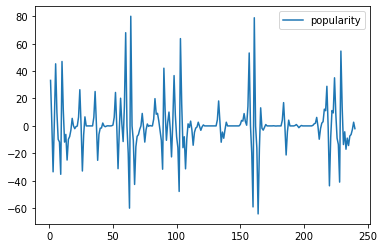

In [124]:

df_graph[['popularity']].diff().plot()

# async


In [3]:
import asyncio
asyncio.get_event_loop()

<_WindowsSelectorEventLoop running=True closed=False debug=False>


# Medley


In [1]:
class SpotifyHandlerTMP():
    
    def __init__(self, env_file_path, playable = False):
        self.sp = self.setup_spotify_connection(env_file_path, playable)
        
    def setup_spotify_connection(self, env_file_path, playable):
        from src.utils import install_pip_pkg
        install_pip_pkg({'spotipy'})

        # import libraries
        import spotipy
        from src.utils import ConfigHandler

        #Initialize SpotiPy with user credentias
        config_handler = ConfigHandler(env_file_path)
        client_keys = config_handler.load_config('spotify')
        
        sp = None
        if playable:
            from spotipy.oauth2 import SpotifyOAuth
            
            # scope explanation 
            # https://developer.spotify.com/documentation/general/guides/authorization/scopes/
            # user-modify-playback-state -> start playing, seeking in a track, next track
            # user-read-playback-state -> get devices
            scope = 'streaming,user-library-read,user-modify-playback-state,user-read-playback-state'
                #,playlist-read-private,playlist-read-collaborative'
                
            self.client_credentials = SpotifyOAuth(
                            client_id=client_keys['client_id'],
                            client_secret=client_keys['client_secret'],
                            redirect_uri=SPOTIFY_REDIRECT_URI,
                            scope=scope,
                            #show_dialog = True,
                            open_browser = True)
            
            sp = spotipy.Spotify(auth_manager=self.client_credentials) # POSSIBLY: True 
            
        else:
            from spotipy.oauth2 import SpotifyClientCredentials
            self.client_credentials = SpotifyClientCredentials(
                            client_id = client_keys['client_id'], 
                            client_secret = client_keys['client_secret'])
            sp = spotipy.Spotify(client_credentials_manager=self.client_credentials,
                             backoff_factor = 3, 
                             retries=3 )
        
        return sp
    
    def get_connection(self):
        return self.sp
    
    def get_token(self, *args):
        return self.client_credentials.get_access_token(*args)
    


In [1]:
import os
from src.SpotifyHandler import SpotifyHandler
SPOTIFY_REDIRECT_URI = 'http://127.0.0.1:8000/spotify/callback/'
sp = SpotifyHandler(os.path.join(os.getcwd(), '.env_spotify'), playable=True)
spotify = sp.get_connection()

In [3]:
sp.client_credentials.get_access_token()
#sp.get_token()#['access_token']

C:\Users\circl\AppData\Local\Temp\ipykernel_16128\2245753373.py:1: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  sp.client_credentials.get_access_token()


{'access_token': 'BQAegg9CtOQQtkzqq7_M6s5jr1LZbq7X6PK0VDPHqbDx_IPp_LknwcTmXeab5uKv6IGjqpwOnizrY36IHYFuJ_-kpdu2nNSsSzE_kJtRTtie7wWMGpXZEhY8FFqgbtiIM3Yw5CeV46YUJsTOGC28AsMIDgYcYSlo23dE__MseANNvtxC_oWSlwgSKBVcmviQHuniwVLoJWFoePwu-uZNdiNu',
 'token_type': 'Bearer',
 'expires_in': 3600,
 'scope': 'streaming user-library-read user-modify-playback-state user-read-email user-read-playback-state user-read-private',
 'expires_at': 1658938161,
 'refresh_token': 'AQB5rz4x_c7dyI18HRVD1l2MhqogjrLycs8x9Fr8hE1TImV4lHB7sZWj_Oc9yvl0j3pqNeAzzAwgSSdz9fxmz08Ft-2uIy0G0htMZ2ecJ8a2zs3IIBSW8KmKwP6uNz9h-mQ'}

In [10]:
response = sp.client_credentials.refresh_access_token(sp.client_credentials.get_access_token()['refresh_token'])

from datetime import datetime as dt 
dt.fromtimestamp(response['expires_at'])

C:\Users\circl\AppData\Local\Temp\ipykernel_16128\2477536223.py:1: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  response = sp.client_credentials.refresh_access_token(sp.client_credentials.get_access_token()['refresh_token'])


datetime.datetime(2022, 7, 27, 18, 21, 37)

In [24]:
spotify.devices()

{'devices': [{'id': '5c1e402d6f163d5ba1125e67fd3165e117ff4bd1',
   'is_active': False,
   'is_private_session': False,
   'is_restricted': False,
   'name': 'prague',
   'type': 'Smartphone',
   'volume_percent': 100},
  {'id': '9f53efdc5e20247e2936acf2d4a2cab2e7ed76d8',
   'is_active': False,
   'is_private_session': False,
   'is_restricted': False,
   'name': 'Web Player (Firefox)',
   'type': 'Computer',
   'volume_percent': 50}]}

In [26]:
spotify.current_playback()

{'device': {'id': '4cb000ee483216c67557cd80a697e7137921687f',
  'is_active': True,
  'is_private_session': False,
  'is_restricted': False,
  'name': 'MEDLEY PLAYER',
  'type': 'Computer',
  'volume_percent': 50},
 'shuffle_state': False,
 'repeat_state': 'off',
 'timestamp': 1658745436700,
 'context': {'external_urls': {'spotify': 'https://open.spotify.com/playlist/5p5kjXeLnbTbivm5gEjPcN'},
  'href': 'https://api.spotify.com/v1/playlists/5p5kjXeLnbTbivm5gEjPcN',
  'type': 'playlist',
  'uri': 'spotify:playlist:5p5kjXeLnbTbivm5gEjPcN'},
 'progress_ms': 353292,
 'item': {'album': {'album_type': 'album',
   'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4vvZMdl6p2XjdcmxA9dRws'},
     'href': 'https://api.spotify.com/v1/artists/4vvZMdl6p2XjdcmxA9dRws',
     'id': '4vvZMdl6p2XjdcmxA9dRws',
     'name': 'Silly',
     'type': 'artist',
     'uri': 'spotify:artist:4vvZMdl6p2XjdcmxA9dRws'},
    {'external_urls': {'spotify': 'https://open.spotify.com/artist/6tos63nhh

In [19]:
spotify.start_playback(
    device_id = '911a8f63f4e1fcd2b3e62b8a7e8bbc79445a40c1', 
    context_uri='spotify:artist:6HCnsY0Rxi3cg53xreoAIm')

In [ ]:
sp.start_playback(device_id=None, uris='list of one track', position_ms={“position”: 'int in ms'} )
current_playback(market=None, additional_types=None)
next_track(device_id=None)
seek_track(position_ms, device_id=None)

# optional
# volume(volume_percent, device_id=None)

# Tests

In [2]:
import asyncio

async def mygen(u: int = 10):
    """Yield powers of 2."""
    i = 0
    while i < u:
        yield 2 ** i
        i += 1
        await asyncio.sleep(0.1)
        
async def main():
    from src.AsyncHandler import AsyncHandler
    # This does *not* introduce concurrent execution
    # It is meant to show syntax only
    item = None
    async for i in mygen():
        item = i
        break
    return item
    
    #print( AsyncHandler().yielder(mygen()))

loop = asyncio.get_event_loop()
await loop.create_task(main())

1

In [1]:
from src.utils import reload_module
reload_module({'name' :'.YoutubeHandler', 'package':'src'})
reload_module({'name' :'.AsyncHandler', 'package':'src'})
from src.YoutubeHandler import YoutubeHandler
from src.AsyncHandler import AsyncHandler
yt = YoutubeHandler(AsyncHandler())
await yt.setup()

-+-+ YoutubeHandler: Starting Proxy Server


C:\Users\circl\anaconda3\lib\site-packages\proxybroker\api.py:97: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  self._on_check = asyncio.Queue(maxsize=max_conn, loop=self._loop)
C:\Users\circl\anaconda3\lib\asyncio\queues.py:48: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  self._finished = locks.Event(loop=loop)


-+-+ SUCCESSFUL


C:\Users\circl\anaconda3\lib\asyncio\trsock.py:20: DeprecationWarning: Using send() method on sockets returned from get_extra_info('socket') will be prohibited in asyncio 3.9. Please report your use case to bugs.python.org.
  warnings.warn(
C:\Users\circl\anaconda3\lib\asyncio\trsock.py:20: DeprecationWarning: Using recv() method on sockets returned from get_extra_info('socket') will be prohibited in asyncio 3.9. Please report your use case to bugs.python.org.
  warnings.warn(
C:\Users\circl\anaconda3\lib\asyncio\trsock.py:20: DeprecationWarning: Using close() method on sockets returned from get_extra_info('socket') will be prohibited in asyncio 3.9. Please report your use case to bugs.python.org.
  warnings.warn(


-+-+ YoutubeHandler: Initialising Selenium Webdriver
-+-+ SUCCESSFUL
-+-+ YoutubeHandler: Initialising Selenium WaitWebdriver
-+-+ SUCCESSFUL


C:\Users\circl\anaconda3\lib\asyncio\trsock.py:20: DeprecationWarning: Using send() method on sockets returned from get_extra_info('socket') will be prohibited in asyncio 3.9. Please report your use case to bugs.python.org.
  warnings.warn(
C:\Users\circl\anaconda3\lib\asyncio\trsock.py:20: DeprecationWarning: Using recv() method on sockets returned from get_extra_info('socket') will be prohibited in asyncio 3.9. Please report your use case to bugs.python.org.
  warnings.warn(
C:\Users\circl\anaconda3\lib\asyncio\trsock.py:20: DeprecationWarning: Using close() method on sockets returned from get_extra_info('socket') will be prohibited in asyncio 3.9. Please report your use case to bugs.python.org.
  warnings.warn(
1.09.74.59:476: Error at creating: 


In [7]:
await yt.ash.yielder(yt.proxy_handler.get_random_proxy)

In [1]:
from src.utils import reload_module
reload_module({'name' :'.MedleyGenerator', 'package':'src'})
from src.MedleyGenerator import MedleyGenerator
mg = MedleyGenerator('Web Player (Firefox)')


2022-07-27 23:56:47.804 
  command:

    streamlit run C:\Users\circl\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
E:\DSBC\DataScienceBC22\final\src\MedleyGenerator.py:14: RuntimeWarning: coroutine 'MedleyGenerator.setup_detour' was never awaited
  self.setup_detour(device_name)


In [1]:
from src.utils import PrintLogger
logger1 = PrintLogger.register()

with logger1('printing'):
    print('this')
    
logger2 = PrintLogger.register()

with logger2('printing'):
    print('this')
    
logger3 = PrintLogger.register()
logger4 = PrintLogger.register()
logger5 = PrintLogger.register()

with logger5('printing'):
    print('this')

-+-+ printing
this
-+-+ SUCCESSFUL
-+-+ printing
this
-+-+ SUCCESSFUL
-+-+ printing
this
-+-+ SUCCESSFUL
